# For cross attention and Unet investigation

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip -q "/content/drive/MyDrive/ECE1508 - GenAI/data_4100_word.zip" -d /content/dataset

from google.colab import drive
drive.mount('/content/drive')

#!unzip -q "/content/drive/MyDrive/data_4100_word.zip" -d /content/dataset
!unzip -q "/content/drive/MyDrive/Colab Notebooks/ECE1508/Project/data_4100_word.zip" -d /content/dataset_4100
!unzip -q "/content/drive/MyDrive/Colab Notebooks/ECE1508/Project/data_4100_word.zip" -d /content/dataset_4100


Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wkvw3z78
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wkvw3z78
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer, BertConfig
import os
import matplotlib.pyplot as plt
import math

In [3]:
# assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"currently running on {device}")

currently running on cuda


# BERT Class

In [5]:
# Dataset Class
class FashionCaptionDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2. - 1.) # map to [-1,1] for centered training
        ])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Extract caption from filename
        caption = self.image_files[idx].replace('.png', '')
        caption = caption.replace('_', ' ').replace('.', ' ')
        caption = ' '.join(caption.split())  # Clean extra spaces

        return self.transform(image), caption

class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.proj = nn.Linear(768, 256)  # Project to smaller dimension
        self.gelu = nn.GELU()

        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, captions):
        inputs = self.tokenizer(
            captions,
            padding=True,
            truncation=True,
            max_length=32,
            return_tensors="pt"
        ).to(device)

        outputs = self.bert(**inputs)
        pooled = outputs.last_hidden_state  # Use [CLS] token representation, it is the embedding from the final hidden layer
        return self.gelu(self.proj(pooled))

In [6]:
#ds = FashionCaptionDataset('/content/drive/MyDrive/Colab Notebooks/ECE1508/Project/mini_dataset')
ds = FashionCaptionDataset('/content/dataset_4100/data_4100_word')
print(len(ds))
test_size = int(0.2 * len(ds))
train_size = len(ds) - test_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

4117


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


(5, 10, 256)


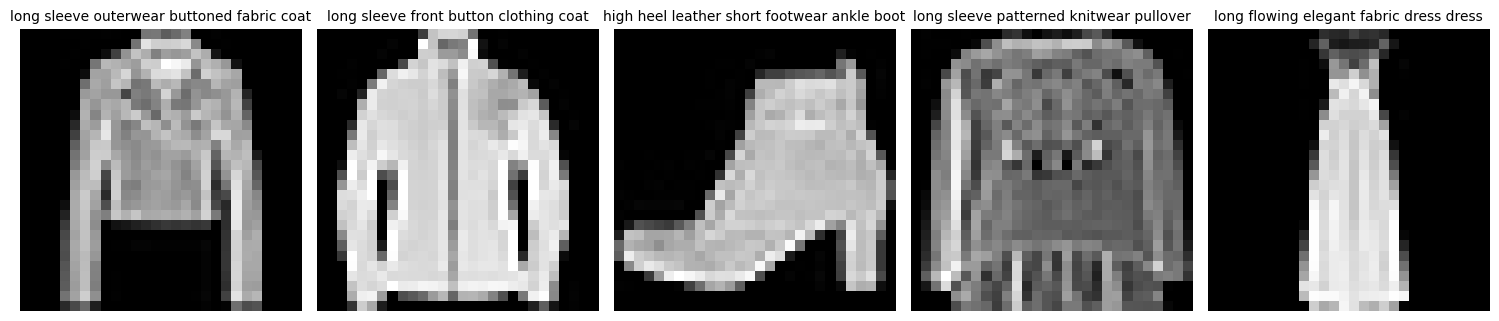


Caption 1: long sleeve outerwear buttoned fabric coat
Embedding shape: (10, 256)

Caption 2: long sleeve front button clothing coat
Embedding shape: (10, 256)

Caption 3: high heel leather short footwear ankle boot
Embedding shape: (10, 256)

Caption 4: long sleeve patterned knitwear pullover
Embedding shape: (10, 256)

Caption 5: long flowing elegant fabric dress dress
Embedding shape: (10, 256)


In [7]:
# Get one batch
x_batch, y_batch = next(iter(train_loader))  # x: [B, 1, 28, 28], y: list of captions
x_batch = x_batch[:5]  # select first 5 samples
y_batch = y_batch[:5]  # corresponding captions

# Send to device and encode
x_batch = x_batch.to(device)
text_encoder = TextEncoder().to(device)


with torch.no_grad():
    text_embeddings = text_encoder(y_batch).cpu().numpy()  # shape: [5, N, 128]
    print(text_embeddings.shape)
# Plot images and print embeddings
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow((x_batch[i].cpu().squeeze() + 1) / 2, cmap='gray')  # inverse normalize
    axs[i].axis('off')
    axs[i].set_title(f"{y_batch[i]}", fontsize=10)

plt.tight_layout()
plt.show()

# Show text embedding summaries
for i in range(5):
    print(f"\nCaption {i+1}: {y_batch[i]}")
    print(f"Embedding shape: {text_embeddings[i].shape}")
    # print(f"Embedding values: {text_embeddings[i][:]}")

# Converting images from pixels to Patches

In [8]:
def convert_image_to_patches(image, patch_size = 4):
  B, ch, weight, height = image.shape

  patch = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
  print(patch.shape)
  patch = patch.permute(0, 2, 3, 1, 4, 5) # [B, patch_height, patch_width, ch, patch_size, patch_size]
  print(patch.shape)
  patch = patch.contiguous().view(B, -1, ch * patch_size * patch_size) # [B, patch_number, patch_size ** 2]
  return patch


print(x_batch.shape)
image_patch = convert_image_to_patches(x_batch, 4)

torch.Size([5, 1, 28, 28])
torch.Size([5, 1, 7, 7, 4, 4])
torch.Size([5, 7, 7, 1, 4, 4])


# Cross Attention between text and image in embedding space

In [9]:
# Text to image cross attention between text to image
class CrossAttention(nn.Module):
  def __init__(self, dim_q, dim_k_v, head=4, dim_head=32, bias_setting=False):
    """
    dim_q: dimension of query --> here should be the embedding size of image features
    dim_k_v: dimension of key and value --> shoube the embedding size of text features
    head: number of heads
    dim_head: dimension of each head
    bias_setting: whether to use bias in the linear layers
    """
    super(CrossAttention, self).__init__()
    self.head = head
    self.dim_head = dim_head
    self.scale = self.dim_head ** -0.5


    self.q = nn.Linear(dim_q, self.dim_head * head, bias=bias_setting)
    self.k = nn.Linear(dim_k_v, self.dim_head * head, bias=bias_setting)
    self.v = nn.Linear(dim_k_v, self.dim_head * head, bias=bias_setting)
    self.out = nn.Linear(self.dim_head * head, dim_q)

  def forward(self, image_query, text_context):
    """
    image_query: used for the image [BS, N_query, dim_q]
    text_context: used for the text [BS, N_context, dim_k_v]
    for all N_query and N_context: N the number of tokens in the sequence
    for image: for a patch of 16 * 16 --> (256 / 16) * (256 / 16) = 256 --> basically to prevent image token to be too long
    """
    BS = image_query.shape[0]
    N_query = image_query.shape[1]
    N_context = text_context.shape[1]

    # for multi head
    # [B, heads, Nq, dim_q]
    q = self.q(image_query)
    q = q.view(BS, N_query, self.head, self.dim_head).transpose(1, 2)

    k = self.k(text_context)
    k = k.view(BS, N_context, self.head, self.dim_head).transpose(1, 2)

    v = self.v(text_context)
    v = v.view(BS, N_context, self.head, self.dim_head).transpose(1, 2)

    # compute attention
    score = torch.matmul(q, k.transpose(-1, -2)) * self.scale
    weights = F.softmax(score, dim=-1)
    output = torch.matmul(weights, v)

    output = output.transpose(1, 2)
    return self.out(output.reshape(BS, N_query, -1)) #[B, N_image, patch_size ** 2]



In [10]:
# some testing coding
# Simulate image tokens
B, N_img, dim_img = 2, 49 + 1, 4 * 4
image_tokens = torch.randn(B, N_img, dim_img)

# Simulate text tokens
N_text, dim_text = 32, 768
text_tokens = torch.randn(B, N_text, dim_text)

# Instantiate and test
attn = CrossAttention(dim_q=16, dim_k_v=768, head=4)
out = attn(image_tokens, text_tokens)  # [B, 256, 512]
print(out.shape)

torch.Size([2, 50, 16])


In [11]:
# Self attention on the images
# the dim variable correspond to image dim
class SelfAttention(nn.Module):
  def __init__(self, dim, head=4, dim_head=32, bias_setting=False):
    """
    dim_q: dimension of query --> here should be the embedding size of image features
    dim_k_v: dimension of key and value --> shoube the embedding size of text features
    head: number of heads
    dim_head: dimension of each head
    bias_setting: whether to use bias in the linear layers
    """
    super(SelfAttention, self).__init__()
    self.head = head
    self.dim_head = dim_head
    self.scale = self.dim_head ** -0.5


    self.q = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.k = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.v = nn.Linear(dim, self.dim_head * head, bias=bias_setting)
    self.out = nn.Linear(self.dim_head * head, dim)

  def forward(self, x):
    BS = x.shape[0]
    N = x.shape[1]

    # for multi head
    # [B, heads, Nq, dim_q]
    q = self.q(x)
    q = q.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    k = self.k(x)
    k = k.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    v = self.v(x)
    v = v.view(BS, N, self.head, self.dim_head).transpose(1, 2)

    # compute attention
    score = torch.matmul(q, k.transpose(-1, -2)) * self.scale
    weights = F.softmax(score, dim=-1)
    output = torch.matmul(weights, v)

    output = output.transpose(1, 2)
    return self.out(output.reshape(BS, N, -1)) #[B, N_image, patch_size ** 2]



# Attention_block

https://arxiv.org/pdf/2112.10752

In [33]:
class CrossAttentionBlock(nn.Module):
  def __init__(self, dim_q, dim_k_v, head=4, dim_head=32, linear_scale=2, dropout=0.5, bias_setting=False):
    super(CrossAttentionBlock, self).__init__()
    self.dim_q = dim_q
    self.dim_k_v = dim_k_v
    self.head = head
    self.dim_head = dim_head
    self.time_embedding = time_embedding
    self.time_embedding = self.time_embedding.to(device)

    # layer norms
    self.layer_norm_attn = nn.LayerNorm(dim_q)
    self.layer_norm_mlp = nn.LayerNorm(dim_q)
    self.layer_norm_self_attn = nn.LayerNorm(dim_q)


    # MLP
    self.mlp = nn.Sequential(
        nn.Linear(dim_q, dim_q * linear_scale),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(dim_q * linear_scale, dim_q)
    )

    # cross attention
    self.cross_attn = CrossAttention(dim_q, dim_k_v, head, dim_head, bias_setting)
    self.self_attn = SelfAttention(dim_q, head, dim_head, bias_setting)

  def forward(self, image, text, timestamp):
    # code begins below
    image = image + timestamp
    # image = self.layer_norm_self_attn(image)
    # image = image + self.self_attn(image)
    image = self.layer_norm_attn(image)
    image = image + self.cross_attn(image, text)
    image = self.layer_norm_mlp(image)
    image = image + self.mlp(image)

    return image



In [34]:
# Image tokens
image_tokens = torch.randn(4, 49, 28*28)  # e.g. 16x16 patches → N=256, dim=512

# Text tokens
text_embeddings = torch.randn(4, 32, 768)  # e.g. from T5 or CLIP

# time embedding
time_embedding = torch.randn(4, 1, 28*28)

block = CrossAttentionBlock(dim_q = 28 * 28, dim_k_v=768,  head=8, dim_head=64, bias_setting=False)
out = block(image_tokens, text_embeddings, time_embedding)
print(out.shape)


torch.Size([4, 49, 784])


In [35]:
def cal_conv2d_shape(width, kernel_size, stride, padding):
    new_width = (width - kernel_size + 2 * padding) // stride + 1
    new_height = new_width
    return new_width, new_height

def transpose_conv2d_output_shape(input_size, kernel_size, stride, padding, output_padding=0):
    new_weight = (input_size - 1) * stride - 2 * padding + kernel_size + output_padding
    new_height = new_weight
    return new_weight, new_height

# Unet V2

In [64]:
class UNet(nn.Module):
  def __init__(self, channel, time_dim, cnn_params, trans_cnn_params, attn_params, bias_settings=False, linear_scale=2, dropout=0.5):
    super(UNet, self).__init__()
    self.channel = channel
    self.bias_settings = bias_settings
    self.linear_scale = linear_scale
    self.dropout = dropout
    self.time_dim = time_dim

    self.relu = nn.ReLU()

    self.attn_dim_k_v = attn_params['dim_k_v']

    # ----- Encoder Convs -----
    self.encoder_T = cnn_params["encoder_T"]
    self.encoder_head = cnn_params["encoder_head"]
    self.encoder_head_dim = cnn_params["encoder_head_dim"]
    self.encoder_bn_layer_norm = nn.LayerNorm(cnn_params['inter_layer_channel'])

    self.conv1 = nn.Conv2d(channel,
                           cnn_params['inter_layer_channel'],
                           cnn_params['kernel_size_1'],
                           cnn_params['stride_1'],
                           cnn_params['padding_1'],
                           bias=bias_settings)

    self.conv2 = nn.Conv2d(cnn_params['inter_layer_channel'],
                           cnn_params['inter_layer_channel_2'],
                           cnn_params['kernel_size_2'],
                           cnn_params['stride_2'],
                           cnn_params['padding_2'],
                           bias=bias_settings)

    self.conv1x1_flatten = nn.Conv2d(cnn_params['inter_layer_channel'],
                                     self.encoder_head * self.encoder_head_dim,
                                     kernel_size=1,
                                     bias = bias_settings
                                     )

    self.conv1x1_unflatten = nn.Conv2d(self.encoder_head * self.encoder_head_dim,
                                     cnn_params['inter_layer_channel'],
                                     kernel_size=1,
                                     bias = bias_settings
                                     )

    self.encoder_attn_block = nn.ModuleList([
        CrossAttentionBlock(
            dim_q = self.encoder_head * self.encoder_head_dim,
            dim_k_v=self.attn_dim_k_v,
            head=self.encoder_head,
            dim_head=self.encoder_head_dim
        )
        for _ in range(self.encoder_T)
    ])

    # ----- Decoder Transpose Convs -----
    # these are conv2d blocks, but just following the naming convention
    self.decoder_T = trans_cnn_params["decoder_T"]
    self.decoder_head = trans_cnn_params["decoder_head"]
    self.decoder_head_dim = trans_cnn_params["decoder_head_dim"]
    self.decoder_bn_layer_norm = nn.LayerNorm(trans_cnn_params['inter_layer_channel_1'])

    self.deconv1 = nn.ConvTranspose2d(cnn_params['inter_layer_channel_2'],
                                      trans_cnn_params['inter_layer_channel_1'],
                                      trans_cnn_params['kernel_size_trans_1'],
                                      trans_cnn_params['stride_trans_1'],
                                      trans_cnn_params['padding_trans_1'],
                                      trans_cnn_params['output_padding_trans_1'],
                                      bias=bias_settings)

    self.deconv2 = nn.ConvTranspose2d(trans_cnn_params['inter_layer_channel_1'],
                                      channel,
                                      trans_cnn_params['kernel_size_trans_2'],
                                      trans_cnn_params['stride_trans_2'],
                                      trans_cnn_params['padding_trans_2'],
                                      trans_cnn_params['output_padding_trans_2'],
                                      bias=bias_settings)

    self.deconv1x1_flatten = nn.Conv2d(trans_cnn_params['inter_layer_channel_1'],
                                     self.decoder_head * self.decoder_head_dim,
                                     kernel_size=1,
                                     bias = bias_settings
                                     )

    self.deconv1x1_unflatten = nn.Conv2d(self.encoder_head * self.encoder_head_dim,
                                     trans_cnn_params['inter_layer_channel_1'],
                                     kernel_size=1,
                                     bias = bias_settings
                                     )

    self.decoder_attn_block = nn.ModuleList([
        CrossAttentionBlock(
            dim_q = self.decoder_head * self.decoder_head_dim,
            dim_k_v=self.attn_dim_k_v,
            head=self.decoder_head,
            dim_head=self.decoder_head_dim
        )
        for _ in range(self.decoder_T)
    ])



    # -------- attn (bottleneck) --------
    self.bn_layer_norm = nn.LayerNorm(cnn_params['inter_layer_channel_2'])

    self.attn_dim_q = attn_params['dim_q']
    self.attn_dim_timestamp = attn_params['dim_timestamp']
    self.attn_head = attn_params['head']
    self.attn_dim_head = attn_params['dim_head']
    self.T = attn_params['T'] # this is the number of stacked attention blocks

    # attention blocks according to T
    self.attn_blocks = nn.ModuleList([
        CrossAttentionBlock(
            dim_q = self.attn_dim_head * self.attn_head,
            dim_k_v=self.attn_dim_k_v,
            head=self.attn_head,
            dim_head=self.attn_dim_head
        )
        for _ in range(self.T)
    ])


    # ------- time projections -------

    self.time_proj = nn.Sequential(
        nn.Linear(self.time_dim, self.channel),
        nn.SiLU(),
    )

    self.time_proj_2 = nn.Sequential(
        nn.Linear(cnn_params["inter_layer_channel_2"], linear_scale * cnn_params["inter_layer_channel_2"]),
        nn.SiLU(),
        nn.Linear(linear_scale * cnn_params["inter_layer_channel_2"], self.attn_dim_head * self.attn_head)
    )

    self.encoder_time_proj = nn.Sequential(
        nn.Linear(cnn_params["inter_layer_channel"], linear_scale * cnn_params["inter_layer_channel"]),
        nn.SiLU(),
        nn.Linear(linear_scale * cnn_params["inter_layer_channel"], self.encoder_head_dim * self.encoder_head)
    )

    self.decoder_time_proj = nn.Sequential(
        nn.Linear(trans_cnn_params["inter_layer_channel_1"], linear_scale * trans_cnn_params["inter_layer_channel_1"]),
        nn.SiLU(),
        nn.Linear(linear_scale * trans_cnn_params["inter_layer_channel_1"], self.decoder_head_dim * self.decoder_head)
    )

    # -------- 1x1 conv ---------
    self.to_bottleneck_conv = nn.Conv2d(cnn_params["inter_layer_channel_2"], self.attn_head * self.attn_dim_head, kernel_size=1, bias=self.bias_settings)
    self.leave_bottleneck_conv = nn.Conv2d(self.attn_head * self.attn_dim_head, cnn_params["inter_layer_channel_2"], kernel_size=1, bias=self.bias_settings)

  def sinusoidal_positional_embedding(self, t, dim):
    denominator = torch.pow(10000, torch.arange(0, dim, 2).float().to(t.device) / dim)
    val = t.float().unsqueeze(-1) / denominator  # (B, dim/2)
    positional_embedding = torch.cat([torch.sin(val), torch.cos(val)], dim=-1)  # (B, dim)
    return positional_embedding # [B, dim]


  def encoder(self, image, text, timestamp):
    # skip connections for Unet architecture
    skip_connections = []

    image = self.conv1(image)
    image = self.relu(image)


    B, C, H, W = image.shape
    image = image.view(B, H, W, C)
    image = self.encoder_bn_layer_norm(image)
    image = image.view(B, C, H, W)

    skip_connections.append(image)

    # atteniton blocks at encoder level
    image = self.conv1x1_flatten(image)

    image = image.view(B, H*W, self.encoder_head * self.encoder_head_dim) # [B, N_image, image_embedding]
    encoder_attn_time_embedding = self.sinusoidal_positional_embedding(timestamp, cnn_params["inter_layer_channel"])
    encoder_attn_time_embedding = self.encoder_time_proj(encoder_attn_time_embedding)
    encoder_attn_time_embedding = encoder_attn_time_embedding.unsqueeze(1)

    for block in self.encoder_attn_block:
      image = block(image, text, encoder_attn_time_embedding)

    image = image.view(B, self.encoder_head * self.encoder_head_dim, H, W)

    image = self.conv1x1_unflatten(image)
    image = image.view(B, C, H, W)

    # second layer of CNN
    image = self.conv2(image)
    image = self.relu(image)
    skip_connections.append(image)
    return image, skip_connections

  def decoder(self, image, text, timestamp, skip_connections):
    image = self.deconv1(image + skip_connections[1])
    image = self.relu(image)

    B, C, H, W = image.shape
    image = image.view(B, H, W, C)
    image = self.decoder_bn_layer_norm(image)
    image = image.view(B, C, H, W)

    skip_connections.append(image)

    # atteniton blocks at encoder level
    image = self.deconv1x1_flatten(image)

    image = image.view(B, H*W, self.decoder_head * self.decoder_head_dim) # [B, N_image, image_embedding]
    decoder_attn_time_embedding = self.sinusoidal_positional_embedding(timestamp, trans_cnn_params["inter_layer_channel_1"])
    decoder_attn_time_embedding = self.encoder_time_proj(decoder_attn_time_embedding)
    decoder_attn_time_embedding = decoder_attn_time_embedding.unsqueeze(1)

    for block in self.decoder_attn_block:
      image = block(image, text, decoder_attn_time_embedding)

    image = image.view(B, self.decoder_head * self.decoder_head_dim, H, W)

    image = self.deconv1x1_unflatten(image)
    image = image.view(B, C, H, W)

    image = self.deconv2(image + skip_connections[0])
    return image


  def forward(self, image, text, timestamp):
    # handle timestamp positional embedding
    time_embedding = self.sinusoidal_positional_embedding(timestamp, self.time_dim)
    time_embedding = self.time_proj(time_embedding)

    B, C = time_embedding.shape
    time_embedding = time_embedding.view(B, C, 1, 1).expand(-1, -1, image.shape[2], image.shape[3])
    image = image + time_embedding

    # handle encoding path of the Unet
    image, skip_connections = self.encoder(image, text, timestamp)
    # handle bottleneck cross attention
    """
    Here is quite complicated and it is strongly recommended to read stable diffusion's paper
    https://arxiv.org/pdf/2112.10752.pdf at page 26
    For our model, we made a lot, i meant a lot of simplifications due to limited resources

    In the original architecture, attention (cross attention is applied in encoder and decoder as well)
    For simplicity, we are putting cross attention in the bottleneck, also we ignored the conv layers in the bottleneck as well
    """
    B, C, H, W = image.shape
    image = image.view(B, H, W, C)
    image = self.bn_layer_norm(image)
    image = image.view(B, C, H, W)

    # conv2d 1x1
    image = self.to_bottleneck_conv(image)

    image = image.view(B, H*W, self.attn_head * self.attn_dim_head) # [B, N_image, image_embedding]

    attn_time_embedding = self.sinusoidal_positional_embedding(timestamp, self.attn_dim_timestamp)
    attn_time_embedding = self.time_proj_2(attn_time_embedding)
    attn_time_embedding = attn_time_embedding.unsqueeze(1)

    for block in self.attn_blocks:
      image = block(image, text, attn_time_embedding)

    image = image.view(B, self.attn_head * self.attn_dim_head, H, W)

    # conv2d 1x1
    image = self.leave_bottleneck_conv(image)
    image = image.view(B, C, H, W)

    # handle decoding path of the Unet
    image = self.decoder(image, text, timestamp, skip_connections)

    return image


# Hyperparameters V1

In [65]:

# cnn_params = {
#     'kernel_size_1': 3,
#     'stride_1': 2,
#     'padding_1': 1,
#     'kernel_size_2': 3,
#     'stride_2': 2,
#     'padding_2': 1,
#     'inter_layer_channel': 32,
#     'inter_layer_channel_2': 64
# }

# trans_cnn_params = {
#     'kernel_size_trans_1': 3,
#     'stride_trans_1': 2,
#     'padding_trans_1': 1,
#     'output_padding_trans_1': 1,
#     'kernel_size_trans_2': 3,
#     'stride_trans_2': 2,
#     'padding_trans_2': 1,
#     'output_padding_trans_2': 1,
#     'inter_layer_channel_1': 32
# }

# attn_params = {
#     'dim_q': 64,             # same as encoder output channel
#     'dim_k_v': 128,           # e.g., text embedding dim
#     'dim_timestamp': 64,     # should match `time_dim`
#     'head': 4,
#     'dim_head': 16,
#     'T': 4                   # number of cross-attention blocks
# }


# # Input image tensor: B x C x H x W
# image = torch.randn(4, 1, 28, 28)  # (B=4, C=3, H=W=64)
# image = image.to(device)

# # Text context
# text = torch.randn(4, 16, 128)  # (B=4, N_text=16, dim_k_v=256)
# text = text.to(device)

# # Timestamp input (e.g., diffusion timestep or sequence index)
# timestamp = torch.tensor([10, 20, 30, 40])  # (B=4,)
# timestamp = timestamp.to(device)

# model = UNet(
#     channel=1,
#     time_dim=64,
#     cnn_params=cnn_params,
#     trans_cnn_params=trans_cnn_params,
#     attn_params=attn_params,
#     bias_settings=False
# )

# model = model.to(device)

# Hyperparameters V2

In [66]:

# ——— beefed-up hyperparams ———

# 1) Conv down/up channels: 1→64→128 then back
cnn_params = {
    'kernel_size_1':         3,
    'stride_1':              2,
    'padding_1':             1,
    'kernel_size_2':         3,
    'stride_2':              2,
    'padding_2':             1,
    'inter_layer_channel':   64,   # was 32 → now 64
    'inter_layer_channel_2': 128,  # was 64 → now 128
    'encoder_T':             4,
    'encoder_head':          2,
    'encoder_head_dim':      32,
}

trans_cnn_params = {
    'kernel_size_trans_1':      3,
    'stride_trans_1':           2,
    'padding_trans_1':          1,
    'output_padding_trans_1':   1,
    'kernel_size_trans_2':      3,
    'stride_trans_2':           2,
    'padding_trans_2':          1,
    'output_padding_trans_2':   1,
    'inter_layer_channel_1':    64,   # this should match cnn_params["inter_layer_channel"]
    'decoder_T':                4,
    'decoder_head':             2,
    'decoder_head_dim':         32,
}

# 2) Cross-attention: 6 blocks, 2 heads × 64-dim each
attn_params = {
    'dim_q':           cnn_params['inter_layer_channel_2'],  # 128
    'dim_k_v':         256,                       # e.g. 128 or 256
    'dim_timestamp':   128,
    'head':            2,     # was 4 → now 2
    'dim_head':        128,    # was 16→ now 64 (so head*dim_head = 128)
    'T':               4,     # was 4 → now 6 cross-attention blocks
}

# ——— instantiate your U-Net with the new params ———
model = UNet(
    channel=1,
    time_dim=128,
    cnn_params=cnn_params,
    trans_cnn_params=trans_cnn_params,
    attn_params=attn_params,
    bias_settings=False
).to(device)


# training

In [67]:
def plot_loss(train_loss_list):
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss Curve")
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 plotting at time 11 ...... 


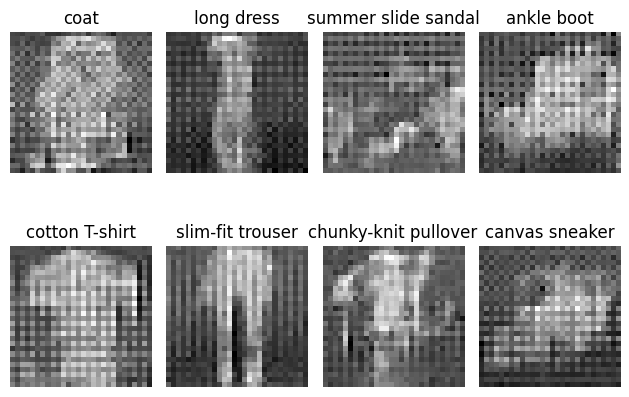


 plotting at time 21 ...... 


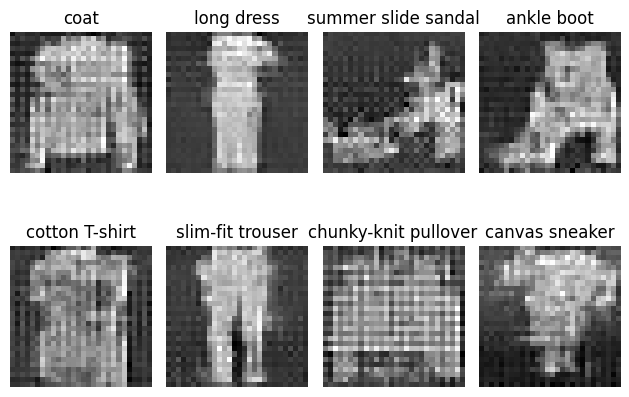


 plotting at time 31 ...... 


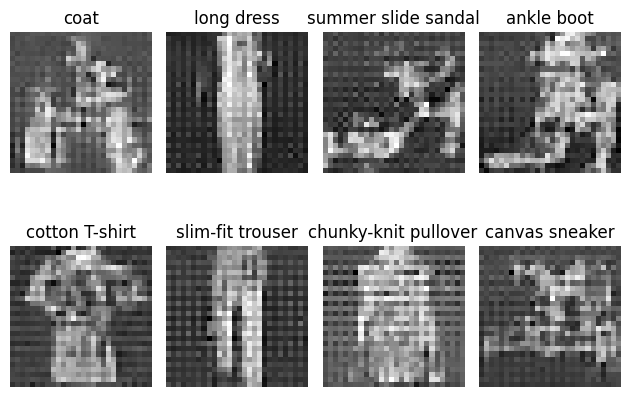


 plotting at time 41 ...... 


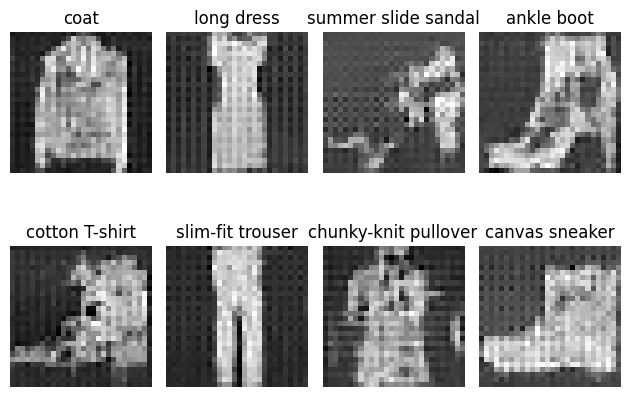


 plotting at time 51 ...... 


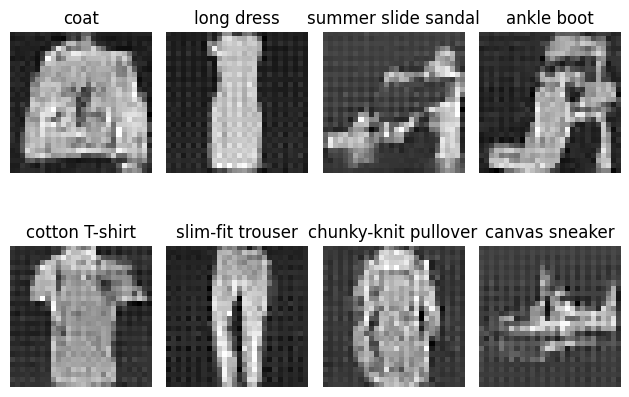


 plotting at time 61 ...... 


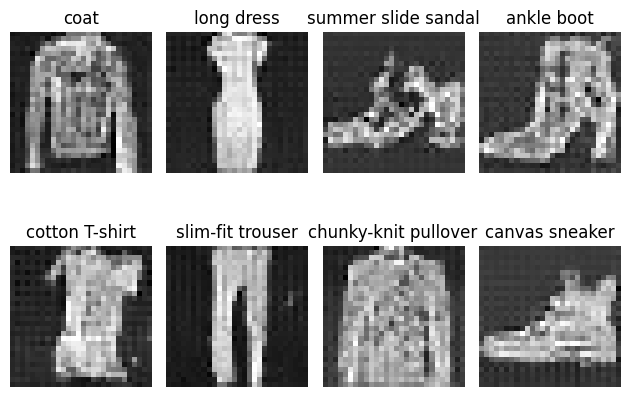


 plotting at time 71 ...... 


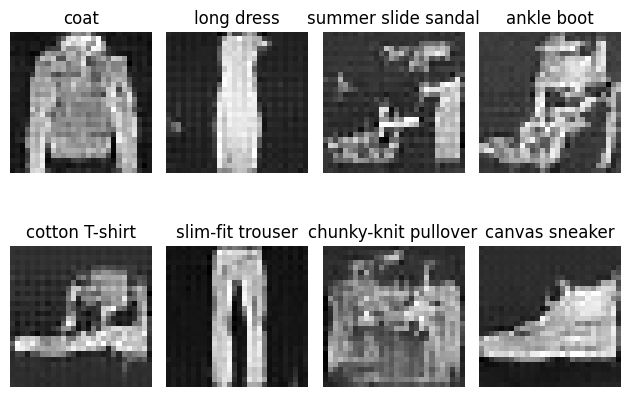


 plotting at time 81 ...... 


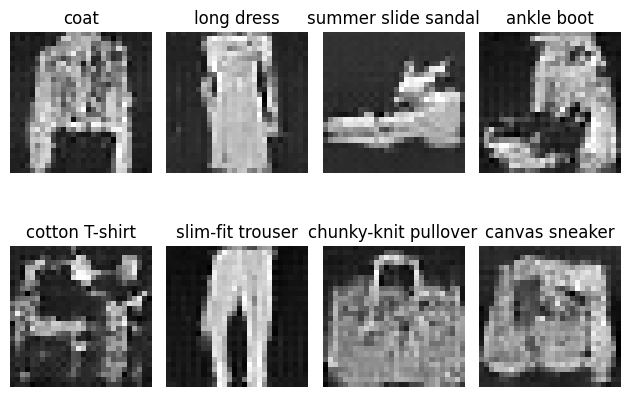


 plotting at time 91 ...... 


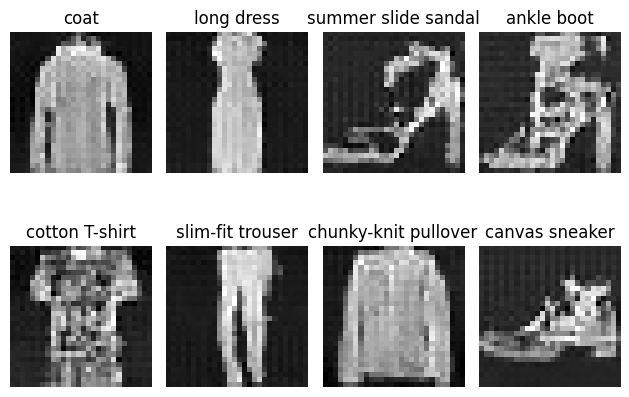

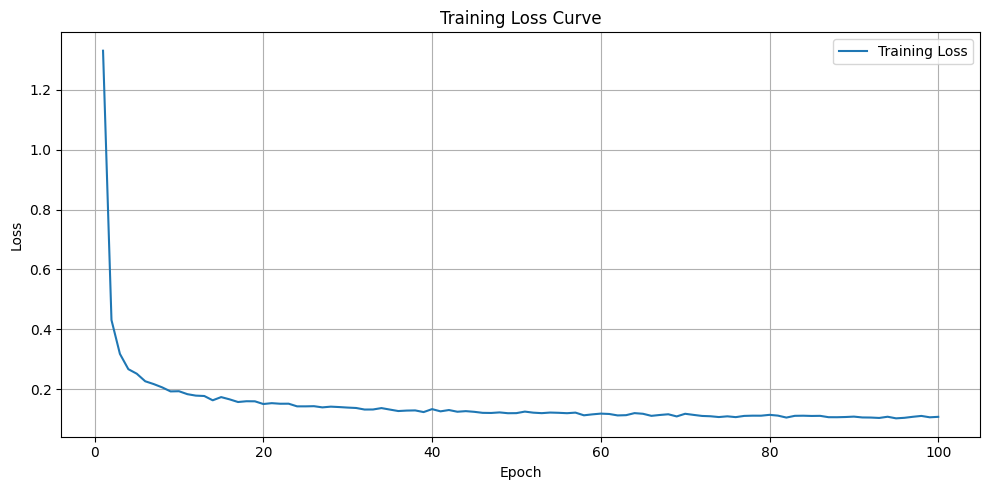

In [68]:
T = 1000 # total diffusion steps

# beta = torch.linspace(1e-4, 0.02, T).to(device)
# alpha = 1. - beta
# alpha_bar = torch.cumprod(alpha, dim=0)  # cumulative
def cosine_beta_schedule(T, s=0.008):
    steps = T + 1
    x     = torch.linspace(0, T, steps, dtype=torch.float64, device=device)
    alphas_cumprod = torch.cos(((x/T + s)/(1 + s)) * math.pi/2)**2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(min=1e-8, max=0.999).float()

beta      = cosine_beta_schedule(T)
alpha     = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Prepare a single “empty” embedding for unconditional runs
empty_tokens       = [""]                # an empty string as “null” prompt
empty_embed_single = text_encoder(empty_tokens).to(device)  # [1, N_text, D_text]

# model instantiate above
#text_encoder = TextEncoder().to(device)
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3)

epochs = 100
train_loss_list = []
drop_prob = 0.1

for epoch in range(epochs):
    model.train()
    text_encoder.eval()
    pbar = tqdm(train_loader)
    pbar.set_description(f"Epoch {epoch + 1} / {epochs}")
    pbar.leave = False
    loss_train = 0
    for x, y in pbar:
        x = x.to(device)  # shape: [B, 1, 28, 28]

        t = torch.randint(0, T, (x.size(0),), device=device)  # random timestep per sample
        alpha_t = alpha_bar[t][:, None, None, None]  # shape: [B, 1, 1, 1]
        # print(alpha_t)
        noise = torch.randn_like(x)
        x_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise

        # 1) Encode captions
        text_embed   = text_encoder(y)                     # torch.Size([B_text, N_text, D_text])
        uncond_embed = torch.zeros_like(text_embed)        # same shape

        # 2) Build per-sample mask from the *text* batch size
        B_text, N_text, D_text = text_embed.shape
        keep = (torch.rand(B_text, device=device) >= drop_prob)     # [B_text]
        mask = keep[:, None, None].expand(B_text, N_text, D_text)   # [B_text, N_text, D_text]

        # 3) Apply classifier-free drop
        text_in = torch.where(mask, text_embed, uncond_embed)       # [B_text, N_text, D_text]

        pred_noise = model(x_t, text_in, t)
        #pred_noise = model(x_t, text_embed, t)
        loss = F.mse_loss(pred_noise, noise)
        loss_train += loss.item()
        pbar.set_postfix(loss=loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_list.append(loss_train / len(train_loader))
    if epoch % 10 == 0 and epoch != 0:
        print(f"\n plotting at time {epoch + 1} ...... ")
        img1 = sample_with_cfg_dynamic_threshold("classic summer outerwear coat", model, text_encoder)
        img2 = sample_with_cfg_dynamic_threshold("formal fashion long dress", model, text_encoder)
        img3 = sample_with_cfg_dynamic_threshold("open toe strappy summer slide sandal", model, text_encoder)
        img4 = sample_with_cfg_dynamic_threshold("texttured high heel modern style ankleboot", model, text_encoder)
        img5 = sample_with_cfg_dynamic_threshold("lightweight casual cotton T-shirt with short sleeves", model, text_encoder)        # class 0: T-shirt/top
        img6 = sample_with_cfg_dynamic_threshold("sleek tailored slim-fit trouser", model, text_encoder)              # class 1: Trouser
        img7 = sample_with_cfg_dynamic_threshold("cozy chunky-knit pullover with ribbed cuffs", model, text_encoder)               # class 2: Pullover
        img8 = sample_with_cfg_dynamic_threshold("streamlined low-top canvas sneaker with minimalist laces", model, text_encoder)  # class 7: Sneaker


        images = [img1, img2, img3, img4, img5, img6, img7, img8]

        titles = [
            "coat",
            "long dress",
            "summer slide sandal",
            "ankle boot",
            "cotton T-shirt",
            "slim-fit trouser",
            "chunky-knit pullover",
            "canvas sneaker",
        ]

        rows, cols = 2, 4
        for idx, (im, title) in enumerate(zip(images, titles)):
            ax = plt.subplot(rows, cols, idx + 1)
            img = (im.squeeze().cpu().clamp(-1, 1) + 1) / 2
            ax.imshow(img, cmap="gray")
            ax.set_title(title)
            ax.axis("off")

        plt.tight_layout()
        plt.show()
plot_loss(train_loss_list)

In [ ]:
@torch.no_grad()
def sample(description, model, text_encoder,seed=42,  img_size=28, T=1000):
    model.eval()
    text_encoder.eval()

    gen = torch.Generator(device=device)
    gen.manual_seed(seed)

    # Step 1: encode label as text embedding
    text_embed = text_encoder([description])

    # Step 2: sample random noise image
    x = torch.randn(1, 1, img_size, img_size, device=device, generator=gen)

    eps = 1e-5  # small epsilon to prevent division/sqrt issues

    for t in reversed(range(T)):
        t_batch = torch.tensor([t], device=device)

        # Predict noise
        pred_noise = model(x, text_embed, t_batch)
        pred_noise = pred_noise.clamp(-1.5, 1.5)  # prevent explosion

        # Get stable α values
        alpha_t = torch.clamp(alpha[t], min=eps)
        alpha_bar_t = torch.clamp(alpha_bar[t], min=eps)

        # DDPM denoising step (deterministic, simplified)
        # x = (x - ((1 - alpha_t).sqrt() * pred_noise / alpha_bar_t.sqrt())) / alpha_t.sqrt()

        # Full DDPM reverse step (mean + variance term)
        beta_t     = beta[t]                          # scalar for this timestep
        # Compute posterior mean
        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = beta_t / torch.sqrt(1 - alpha_bar_t)
        mean  = coef1 * (x - coef2 * pred_noise)

        # Add the correct amount of noise
        sigma_t = torch.sqrt(beta_t)
        noise   = torch.randn_like(x)
        x       = mean + sigma_t * noise


        # clamp or check for NaNs
        if torch.isnan(x).any():
            print(f"NaN detected at timestep {t}")
            break

    return x

In [20]:
@torch.no_grad()
def sample_with_cfg(description, model, text_encoder, seed=42,
                    img_size=28, T=1000, w=1.8):
    model.eval()
    text_encoder.eval()

    # 1) Prepare embeddings
    cond_embed   = text_encoder([description]).to(device)   # [1, N, D]
    uncond_embed = empty_embed_single                       # [1, N, D]

    # 2) Initialize noise
    gen = torch.Generator(device=device).manual_seed(seed)
    x = torch.randn(1, 1, img_size, img_size, device=device, generator=gen)

    eps = 1e-5
    for t in reversed(range(1, T)):
        t_batch = torch.tensor([t], device=device)

        # clamp to avoid NaNs
        a_t     = torch.clamp(alpha[t],     min=eps)
        ab_t    = torch.clamp(alpha_bar[t], min=eps)

        # 3) get conditional & unconditional predictions
        eps_uncond = model(x, uncond_embed, t_batch)
        eps_cond   = model(x, cond_embed,   t_batch)
        eps_pred   = eps_uncond + w * (eps_cond - eps_uncond)

        # 4) compute posterior mean & variance (full DDPM)
        coef1 = 1.0 / torch.sqrt(a_t)
        coef2 = beta[t] / torch.sqrt(1 - ab_t)
        mean  = coef1 * (x - coef2 * eps_pred)

        ab_prev = alpha_bar[t-1] if t > 1 else torch.tensor(1.0, device=device)
        tilde_beta = beta[t] * (1 - ab_prev) / (1 - ab_t)
        sigma_t    = torch.sqrt(tilde_beta)

        # 5) sample x_{t-1}
        noise = torch.randn_like(x) if t > 1 else 0
        x = mean + sigma_t * noise

    return x


In [22]:
@torch.no_grad()
def sample_with_cfg_dynamic_threshold(
    description,
    model,
    text_encoder,
    seed=42,
    img_size=28,
    guidance_scale=2.0,
    p_clip=0.995
):
    model.eval()
    text_encoder.eval()

    # 1) Prepare embeddings
    cond_embed   = text_encoder([description]).to(device)   # [1, N, D]
    uncond_embed = empty_embed_single                       # [1, N, D]

    # 2) Initialize noise
    gen = torch.Generator(device=device).manual_seed(seed)
    x = torch.randn(1, 1, img_size, img_size, device=device, generator=gen)

    eps = 1e-5
    T_steps = beta.shape[0]

    for t in reversed(range(1, T_steps)):
        t_batch = torch.tensor([t], device=device)

        # clamp to avoid NaNs
        a_t  = torch.clamp(alpha[t],     min=eps)
        ab_t = torch.clamp(alpha_bar[t], min=eps)

        # 3) get conditional & unconditional predictions
        eps_uncond = model(x, uncond_embed, t_batch)
        eps_cond   = model(x, cond_embed,   t_batch)
        eps_pred   = eps_uncond + guidance_scale * (eps_cond - eps_uncond)
        # eps_pred   = eps_uncond

        # 4) Predict x0 and apply dynamic thresholding
        sqrt_ab_t   = torch.sqrt(ab_t)
        sqrt_1_ab_t = torch.sqrt(1 - ab_t)
        x0_pred = (x - sqrt_1_ab_t * eps_pred) / sqrt_ab_t

        # compute clipping bound
        flat = x0_pred.view(-1).abs()
        s = torch.quantile(flat, p_clip).item()
        s = max(s, 1.0)  # ensure >=1 to avoid amplifying
        x0_pred = x0_pred.clamp(-s, s) / s

        # 5) recompute eps_pred from thresholded x0_pred
        eps_pred = (x - sqrt_ab_t * x0_pred) / sqrt_1_ab_t

        # 6) compute posterior mean & variance
        coef1 = 1.0 / torch.sqrt(a_t)
        coef2 = beta[t] / torch.sqrt(1 - ab_t)
        mean  = coef1 * (x - coef2 * eps_pred)

        ab_prev    = alpha_bar[t-1] if t > 1 else torch.tensor(1.0, device=device)
        tilde_beta = beta[t] * (1 - ab_prev) / (1 - ab_t)
        sigma_t    = torch.sqrt(tilde_beta)

        # 7) sample x_{t-1}
        noise = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
        x = mean + sigma_t * noise

    return x

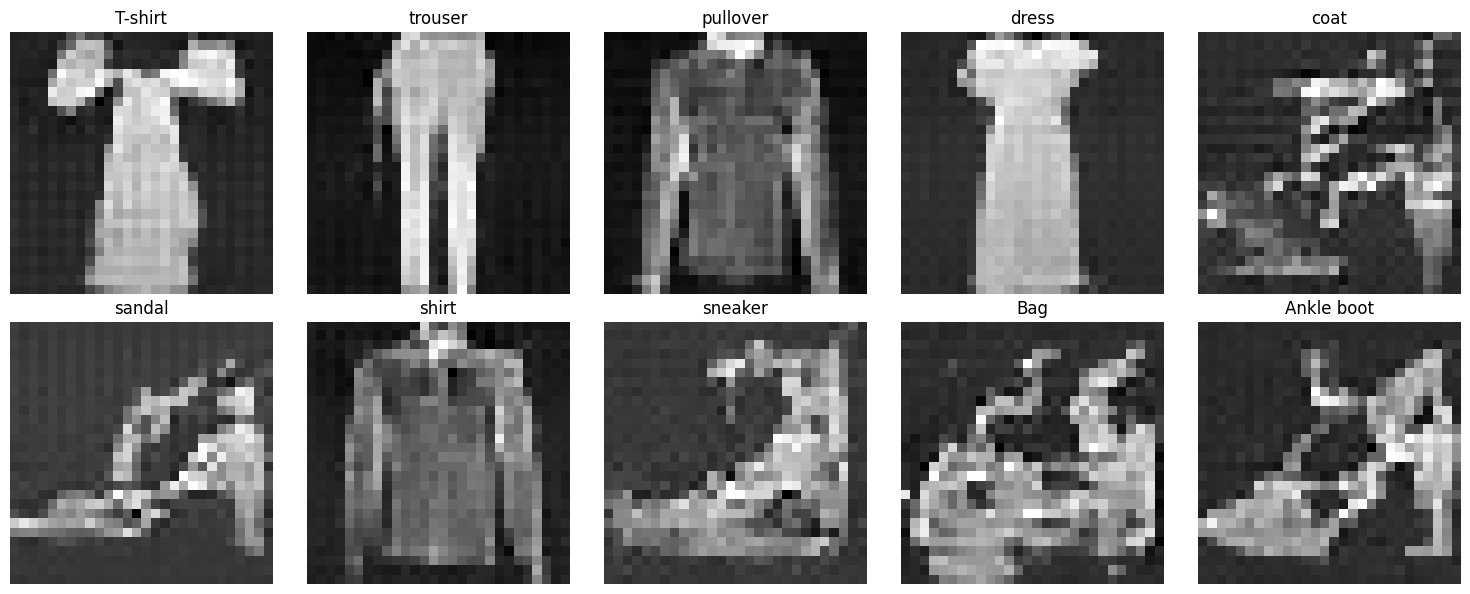

In [79]:
import matplotlib.pyplot as plt

# img1 = sample("classic summer outerwear coat", model, text_encoder, T)
# img2 = sample("formal fashion long dress", model, text_encoder)
# img3 = sample("open toe strappy summer slide sandal", model, text_encoder)
# img4 = sample("texttured high heel modern style ankleboot", model, text_encoder)
# img1 = sample_with_cfg("classic summer outerwear coat", model, text_encoder, T=T)
# img2 = sample_with_cfg("formal fashion long dress", model, text_encoder, T=T)
# img3 = sample_with_cfg("open toe strappy summer slide sandal", model, text_encoder, T=T)
# img4 = sample_with_cfg("texttured high heel modern style ankleboot", model, text_encoder, T=T)
# img5 = sample_with_cfg("lightweight casual cotton T-shirt with short sleeves", model, text_encoder, T=T)        # class 0: T-shirt/top
# img6 = sample_with_cfg("sleek tailored slim-fit trousers", model, text_encoder,T=T)              # class 1: Trouser
# img7 = sample_with_cfg("cozy chunky-knit pullover with ribbed cuffs", model, text_encoder, T=T)               # class 2: Pullover
# img8 = sample_with_cfg("streamlined low-top canvas sneaker with minimalist laces", model, text_encoder, T=T)  # class 7: Sneaker
# img1 = sample_with_cfg_dynamic_threshold("classic summer outerwear coat", model, text_encoder)
# img2 = sample_with_cfg_dynamic_threshold("formal fashion long dress", model, text_encoder)
# img3 = sample_with_cfg_dynamic_threshold("open toe strappy summer slide sandal", model, text_encoder)
# img4 = sample_with_cfg_dynamic_threshold("texttured high heel modern style ankleboot", model, text_encoder)
# img5 = sample_with_cfg_dynamic_threshold("lightweight casual cotton T-shirt with short sleeves", model, text_encoder)        # class 0: T-shirt/top
# img6 = sample_with_cfg_dynamic_threshold("sleek tailored slim-fit trousers", model, text_encoder)              # class 1: Trouser
# img7 = sample_with_cfg_dynamic_threshold("cozy chunky-knit pullover with ribbed cuffs", model, text_encoder)               # class 2: Pullover
# img8 = sample_with_cfg_dynamic_threshold("streamlined low-top canvas sneaker with minimalist laces", model, text_encoder)  # class 7: Sneaker


# images = [img1, img2, img3, img4, img5, img6, img7, img8]

# titles = [
#     "coat",
#     "long dress",
#     "summer slide sandal",
#     "ankle boot",
#     "cotton T-shirt",
#     "slim-fit trouser",
#     "chunky-knit pullover",
#     "canvas sneaker",
# ]

# rows, cols = 2, 4
# for idx, (im, title) in enumerate(zip(images, titles)):
#     ax = plt.subplot(rows, cols, idx + 1)
#     img = (im.squeeze().cpu().clamp(-1, 1) + 1) / 2
#     ax.imshow(img, cmap="gray")
#     ax.set_title(title)
#     ax.axis("off")

# plt.tight_layout()
# plt.show()


import matplotlib.pyplot as plt

# # Generate one sample per Fashion-MNIST class with simple prompts
img1  = sample_with_cfg_dynamic_threshold("cozy plain short sleeve T-shirt", model, text_encoder)  # class 0
img2  = sample_with_cfg_dynamic_threshold("long bright straight leg trouser",      model, text_encoder)  # class 1
img3  = sample_with_cfg_dynamic_threshold("cotton modern style pullover sweater",           model, text_encoder)  # class 2
img4  = sample_with_cfg_dynamic_threshold("bright traditional long wedding dress ",        model, text_encoder)  # class 3
img5  = sample_with_cfg_dynamic_threshold("leather high end spring coat",          model, text_encoder)  # class 4
img6  = sample_with_cfg_dynamic_threshold("open-toe summer slide sandal",            model, text_encoder)  # class 5
img7  = sample_with_cfg_dynamic_threshold("formal button-down professional shirt",          model, text_encoder)  # class 6
img8  = sample_with_cfg_dynamic_threshold("a low-top canvas minimalist sneaker",     model, text_encoder)  # class 7
img9  = sample_with_cfg_dynamic_threshold("fashion classic designer big tote bag",             model, text_encoder)  # class 8
img10 = sample_with_cfg_dynamic_threshold("texttured high heel modern style ankleboot",        model, text_encoder)  # class 9

# Collect images and titles
images = [img1, img2, img3, img4, img5, img6, img7, img8, img9, img10]
titles = [
    "T-shirt", "trouser", "pullover", "dress", "coat", "sandal",
    "shirt", "sneaker",  "Bag",   "Ankle boot"
]

# Plot in a 2×5 grid
rows, cols = 2, 5
plt.figure(figsize=(15, 6))
for idx, (im, title) in enumerate(zip(images, titles)):
    ax = plt.subplot(rows, cols, idx + 1)
    img = (im.squeeze().cpu().clamp(-1, 1) + 1) / 2
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


# LIVE TEST Through user input


Describe an fashion clothing: black_flat_rubber_footwear_sneaker


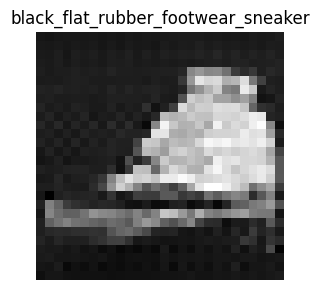

In [77]:
def live_gen():
  desc = input("Describe an fashion clothing: ")
  img = sample_with_cfg_dynamic_threshold(desc, model, text_encoder, T)
  plt.figure(figsize=(12, 3))
  plt.imshow((img.squeeze().cpu().clamp(-1, 1) + 1) / 2, cmap='gray')
  plt.title(desc)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

live_gen()

# save model functon calls

In [82]:
# Save only the state_dict (recommended)
torch.save(model.state_dict(), 'dynamic_thresholding_cfg_unet_v2_with_cross_attention_model.pth')

# Save the entire model
# torch.save(model, 'dynamic_thresholding_cfg_unet_v2_with_cross_attention_model')